# DS4400 Final Project Source Code

Zach O'Brien

December 2022

# 0. Set up Development Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Data Preparation

These are helper functions, this cell can be left minimized:

In [2]:
def preprocess_bikeshare_data(df, categorical_cols, label_col):
    """Preprocess the Bikeshare Ridership Data
    
    One-hot encodes categorical columns, and applies MinMaxScaler to the
    label column "cnt" because it will be a feature as well as a label
    in the time series models.
    
    Args:
        df (pd.DataFrame):
            Data
        categorical_cols (list[str]):
            Names of columns to one-hot encode
        label_col (str):
            Name of the label column (column with label)
    
    Returns:
        pd.DataFrame, MinMaxScaler:
            Data with categorical values one-hot encoded and labels scaled,
            and the scaler fit to the original label range
    """
    new_df = one_hot_encode(df, column_names=categorical_cols)
    new_df, scaler = min_max_scale(new_df, col=label_col)
    return new_df, scaler


def min_max_scale(df, col):
    """Apply MinMax scaling to one column in a DataFrame
    
    Args:
        df (pd.DataFrame):
            Data with a column of real values named `col`
        col (str):
            Name of the column to scale
    
    Returns:
        (pd.Dataframe, MinMaxScaler):
            The Data with `col` scaled, as well as the fit MinMaxScaler so that
            data can be inverse transformed back into the original scale
    """
    scaler = MinMaxScaler()
    df_copy = df.copy()
    label_data = df_copy[col].to_numpy().reshape(-1, 1)
    scaler.fit(label_data)
    df_copy[col] = scaler.transform(label_data)
    return df_copy, scaler
    
    
def one_hot_encode(df, column_names):
    """One-hot encode columns in a DataFrame

    Args:
        df (pd.DataFrame): 
            Data
        column_names (list[str]): 
            Names of columns which should be converted to one-hot encoding

    Returns:
        pd.DataFrame:
            Data with the specified columns converted to one-hot encoding
    """
    df_copy = df.copy()
    dummies = [pd.get_dummies(df_copy[col], prefix=col) for col in column_names]
    df_copy.drop(column_names, axis=1, inplace=True)
    return pd.concat(dummies + [df_copy], axis=1)

In [3]:
data_file = "data/day.csv"
daily_df = pd.read_csv(data_file)
daily_df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


### Visualization of the daily ridership counts over the span of the dataset

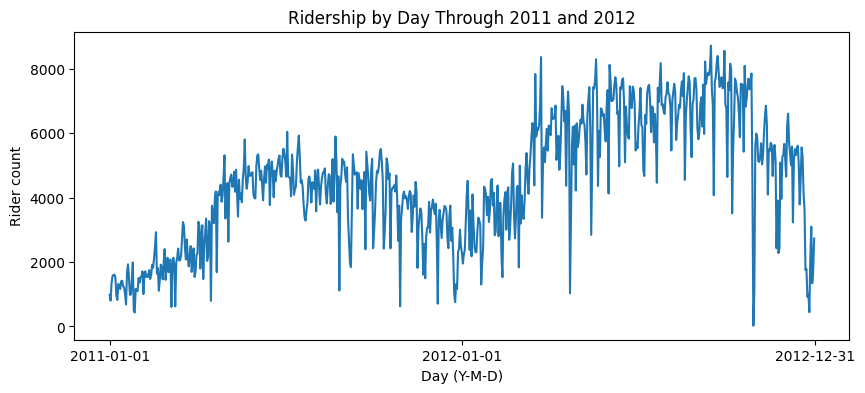

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily_df["cnt"])
ax.set_xlabel("Day (Y-M-D)")
ax.set_ylabel("Rider count")
ax.set_title("Ridership by Day Through 2011 and 2012")
ax.set_xticks([0, len(daily_df)//2, len(daily_df)], labels=daily_df["dteday"][[0, len(daily_df)//2, len(daily_df)-1]])
plt.show()

In [5]:
# Define which columns we want to keep for model training
categorical_columns = ["season", "holiday", "weekday", "workingday", "weathersit"]
continuous_columns = ["temp", "atemp", "hum", "windspeed"]
feature_columns = categorical_columns + continuous_columns
label_column = "cnt"
# Only keep features and target
daily_df = daily_df[feature_columns + [label_column]]

In [6]:
# Preprocess the data by one-hot encoding the categorical features
# and MinMaxScale-ing the label, because it will also be used as a feature (the previous day's count)
preprocessed_daily_df, daily_label_scaler = preprocess_bikeshare_data(daily_df, categorical_cols=categorical_columns, label_col=label_column)
preprocessed_daily_df.describe()

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,...,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.247606,0.251710,0.257182,0.243502,0.971272,0.028728,0.143639,0.143639,0.142271,0.142271,...,0.316005,0.683995,0.633379,0.337893,0.028728,0.495385,0.474354,0.627894,0.190486,0.515687
std,0.431917,0.434293,0.437380,0.429489,0.167155,0.167155,0.350963,0.350963,0.349567,0.349567,...,0.465233,0.465233,0.482212,0.473316,0.167155,0.183051,0.162961,0.142429,0.077498,0.222873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.059130,0.079070,0.000000,0.022392,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.337083,0.337842,0.520000,0.134950,0.360101
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.498333,0.486733,0.626667,0.180975,0.520709
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.655417,0.608602,0.730209,0.233214,0.682697
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.861667,0.840896,0.972500,0.507463,1.000000


# 2. Non-LSTM Models Training and Evaluation

## 2.1 Create Cross Validation Data for All Models Except LSTM Model

The LSTM model will be trained on hourly data instead of daily data to predict the next day's count. So, its data preparation will be a little different.

In [7]:
X = preprocessed_daily_df.iloc[:-1, :].to_numpy()
y = preprocessed_daily_df[[label_column]].iloc[1:, :].to_numpy()

print(f"Inputs have shape: {X.shape}")
print(f"Labels have shape: {y.shape}")

Inputs have shape: (730, 23)
Labels have shape: (730, 1)


In [8]:
def create_train_val_test_timeseries_splits(data, n_splits):
    """Create train, validation, and testing sets for timeseries cross validation
    
    Args:
        data (ndarray): 2D array of input samples
        n_splits (int): Number of subsets for cross validation
    
    Returns:
        list[tuple]: Each tuple is (TRAIN_INDICES, VALIDATION_INDICES, TEST_INDICES)
    """
    timeseries_crossval = TimeSeriesSplit(n_splits=5)
    indices = list(timeseries_crossval.split(data))
    # Split groups into TRAIN, VALIDATION, and TEST sets. Rather than just train/test
    indices = [(
        train, holdout[:len(holdout)//2], holdout[len(holdout)//2:]) 
        for train, holdout in indices
    ]
    return indices

In [40]:
train_set_pct = 0.9
train_set_size = int(len(X)*train_set_pct)

#X_train = X[int(len(x)*TRAIN_SET_PCT):]

# Create TRAIN, VALIDATION, and TEST sets for time series cross validation
crossval_indices = create_train_val_test_timeseries_splits(X, n_splits=5)

In [ ]:
train_set_size

In [10]:
crossval_indices[0]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124]),
 array([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
 

## 2.2 Evaluate Naive Baseline Model

In [11]:
def baseline_model(input_vectors, cnt_col):
    """A naive model which simply uses the previous day's count
       as the prediction for today"""
    return input_vectors[:, cnt_col]

In [12]:
# The column with the previous day's count is the last item in the vector
RIDERSHIP_COUNT_IDX = X.shape[1] - 1  

# Record root mean squared error for each cross validation set
rmse_scores_baseline = []
for train_indices, validation_indices, test_indices in crossval_indices:
    X_train, y_train = X[train_indices], y[train_indices]
    X_validation, y_validation = X[validation_indices], y[validation_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    baseline_predictions = baseline_model(X_test, cnt_col=RIDERSHIP_COUNT_IDX)
    rmse_scores_baseline.append(mean_squared_error(y_test, baseline_predictions, squared=False))

# The count was MinMaxScaled to use in model training. But for better interpretability of
# the results, it is transformed back to its original value here
avg_rmse_score_baseline = daily_label_scaler.inverse_transform(np.average(rmse_scores_baseline).reshape(-1, 1))
print("Average RMSE for Naive Baseline Model:")
print(avg_rmse_score_baseline)

Average RMSE for Naive Baseline Model:
[[1050.50580846]]


## 2.3 Train and Evaluate Linear and Ridge Regression Models

In [13]:
def evaluate_linear_model(model, X, y, ts_crossvalidation_indices):
    """Evaluate a linear model using timeseries cross validation
    
    Args:
        model: A class which can be trained with .fit() and has .predict() to make predictions
        X (ndarray): A 2D array of float values, inputs to the model
        y (ndarray): A 1d array of float values, labels for the inputs
        ts_crossvalidation_indices(list[tuple]): A list of indices for training and testing sets
                                                 to perform timeseries cross validation
    
    Returns:
        list[float]: RMSE scores for each cross validation subset
    """
    rmse_scores = []
    for train_indices, validation_indices, test_indices in ts_crossvalidation_indices:
        model = sklearn.base.clone(model)  # Reset the model parameters
        X_train, y_train = X[train_indices], y[train_indices]
        X_validation, y_validation = X[validation_indices], y[validation_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse_scores.append(mean_squared_error(y_test, predictions, squared=False))
    return rmse_scores

### 2.3.1 Linear Regression Model

In [14]:
rmse_scores_linear = evaluate_linear_model(linear_model.LinearRegression(), X, y, crossval_indices)
print(rmse_scores_linear)
# Same as before, the count was MinMaxScaled to use in model training. But for better interpretability of
# the results, it is transformed back to its original value here
avg_rmse_score_linear = daily_label_scaler.inverse_transform(np.average(rmse_scores_linear).reshape(-1, 1))
print("Average RMSE for Linear Regression Model:")
print(avg_rmse_score_linear)

[0.09761251967397336, 3874965548950.5376, 0.22228626160280013, 0.11530664006988747, 0.11099494956760668]
Average RMSE for Linear Regression Model:
[[6.73624011e+15]]


### 2.3.2 Linear Ridge Regression Model

In [15]:
for alpha in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    rmse_scores_ridge = evaluate_linear_model(linear_model.Ridge(alpha=alpha), X, y, crossval_indices)
    avg_rmse_score_ridge = daily_label_scaler.inverse_transform(np.average(rmse_scores_ridge).reshape(-1, 1))
    print(f"Average RMSE for Ridge Regression Model (alpha={alpha}):")
    print(avg_rmse_score_ridge)

Average RMSE for Ridge Regression Model (alpha=0.0001):
[[1142.9285265]]
Average RMSE for Ridge Regression Model (alpha=0.001):
[[1147.04567753]]
Average RMSE for Ridge Regression Model (alpha=0.01):
[[1159.49796262]]
Average RMSE for Ridge Regression Model (alpha=0.1):
[[1174.50694135]]
Average RMSE for Ridge Regression Model (alpha=1):
[[1280.96222221]]
Average RMSE for Ridge Regression Model (alpha=10):
[[1613.41425541]]


## 2.4 Train and Evaluate Feedforward Neural Network

In [16]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [17]:
class BikeshareDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        self.dataset_size = len(self.y)
    
    def __len__(self):
        return self.dataset_size
        
    def __getitem__(self, idx):
        feature_vec = self.X[idx]
        label = self.y[idx]
        return feature_vec, label
    
    
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(23, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    error = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).numpy()
            error += mean_squared_error(y.numpy(), pred, squared=False)   
    error /= num_batches
    return error

In [19]:
rmse_scores_feedforward_nn = []
for train_indices, validation_indices, test_indices in crossval_indices:
    model = NeuralNetwork()  # Reset the model parameters
    learning_rate = .01
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_dataloader = DataLoader(BikeshareDataset(X[train_indices], y[train_indices]), batch_size=64, shuffle=False)
    validation_dataloader = DataLoader(BikeshareDataset(X[validation_indices], y[validation_indices]), batch_size=64, shuffle=False)
    test_dataloader = DataLoader(BikeshareDataset(X[test_indices], y[test_indices]), batch_size=64, shuffle=False)
    epochs = 1000
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer)
    rmse_scores_feedforward_nn.append(test_loop(test_dataloader, model, loss_fn))
    
print(rmse_scores_feedforward_nn)
avg_rmse_score_ridge_feedforward_nn = daily_label_scaler.inverse_transform(np.average(rmse_scores_feedforward_nn).reshape(-1, 1))
print(f"Average RMSE for Feedforward Neural Network")
print(avg_rmse_score_ridge_feedforward_nn)


/home/zach/Desktop/ds4400/final-project/env/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[0.22353516519069672, 0.10429028421640396, 0.2804020941257477, 0.15406987071037292, 0.12922653555870056]
Average RMSE for Feedforward Neural Network
[[1571.82523434]]


# 3. LSTM Model Dataprep, Training, and Evaluation

In [20]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info
import keras
from keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD

In [21]:
data_file = "data/hour.csv"
hourly_df = pd.read_csv(data_file)

In [22]:
def nearest_fill_missing_hours(data):
    """Fill missing hours with the nearest available data"""
    data_copy = data.copy()
    data_copy = (
        data_copy
        .set_index("hr")
        .reindex(list(range(24)), method="nearest")
        .reset_index())
    return data_copy

In [23]:
# The hourly data has missing values, so fill them with the nearest available data
hourly_df = hourly_df.groupby("dteday").apply(nearest_fill_missing_hours).reset_index(drop=True)
hourly_df.head(3)

,hr,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [24]:
# We'll need the total count on each day, it is the label
count_by_day = hourly_df[["dteday", "cnt"]].groupby("dteday").sum()

# Remove any unneeded columns
hourly_df = hourly_df[feature_columns + [label_column]]
preprocessed_hourly_df, hourly_label_scaler = preprocess_bikeshare_data(hourly_df, categorical_cols=categorical_columns, label_col=label_column)

# Apply the MinMaxScaler to the daily counts
count_by_day["cnt"] = hourly_label_scaler.transform(np.array(count_by_day["cnt"]).reshape(-1, 1))

In [25]:
HOURS_PER_DAY = 24
TOTAL_NUM_DAYS = len(hourly_df) / HOURS_PER_DAY

# Input samples will be all except the hourly measurements taken on the last day,
# because we don't have a label for that day (i.e., no data for the day after it)
X = preprocessed_hourly_df.iloc[:-HOURS_PER_DAY, :].to_numpy()

# Labels will be the sum of each 24 hour period. I.e., total ridership in one day.
# CANNOT use the raw daily data for this, as hourly values have been nearest-filled
y = np.apply_along_axis(sum, 1, np.array_split(np.array(preprocessed_hourly_df["cnt"][HOURS_PER_DAY:]), TOTAL_NUM_DAYS - 1))

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (17520, 24)
y shape: (730,)


In [26]:
crossval_indices = create_train_val_test_timeseries_splits(X, n_splits=5)

In [27]:
SAMPLING_RATE=1
BATCH_SIZE=64

lstm_datasets = []
for train_indices, validation_indices, test_indices in crossval_indices:
    X_train = X[train_indices]
    y_train = y[train_indices // HOURS_PER_DAY]
    X_val = X[validation_indices]
    y_val = y[validation_indices // HOURS_PER_DAY]
    X_test = X[test_indices]
    y_test = y[test_indices // HOURS_PER_DAY]
    
    train_dataset = timeseries_dataset_from_array(
        data=X_train,
        targets=y_train,
        sampling_rate=SAMPLING_RATE,
        sequence_length=HOURS_PER_DAY,
        batch_size=BATCH_SIZE)

    validation_dataset = timeseries_dataset_from_array(
        data=X_val,
        targets=y_val,
        sampling_rate=SAMPLING_RATE,
        sequence_length=HOURS_PER_DAY,
        batch_size=BATCH_SIZE)
    
    test_dataset = timeseries_dataset_from_array(
        data=X_test,
        targets=y_test,
        sampling_rate=SAMPLING_RATE,
        sequence_length=HOURS_PER_DAY,
        batch_size=BATCH_SIZE)

    lstm_datasets.append((train_dataset, validation_dataset, test_dataset))
    
print(f"There are {len(lstm_datasets)} splits for LSTM timeseries cross validation")

There are 5 splits for LSTM timeseries cross validation


In [34]:
FEATURE_VEC_SIZE = 24
LEARNING_RATE=1e-4

model = Sequential()
model.add(keras.Input(shape=(HOURS_PER_DAY, FEATURE_VEC_SIZE)))  # `None` indicates the sequence is of arbitrary length
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(16))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
              loss="mean_squared_error", 
              metrics=["mae"])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 16)            2624      
                                                                 
 dropout_1 (Dropout)         (None, 24, 16)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,753
Trainable params: 4,753
Non-trainable params: 0
_________________________________________________________________


In [35]:
histories = []
for i, (train_dataset, validation_dataset, test_dataset) in enumerate(lstm_datasets):
    print(f"Fitting model on crossval split {i+1}")
    history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=0)
    histories.append(history)

Fitting model on crossval split 1
Fitting model on crossval split 2
Fitting model on crossval split 3
Fitting model on crossval split 4
Fitting model on crossval split 5


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

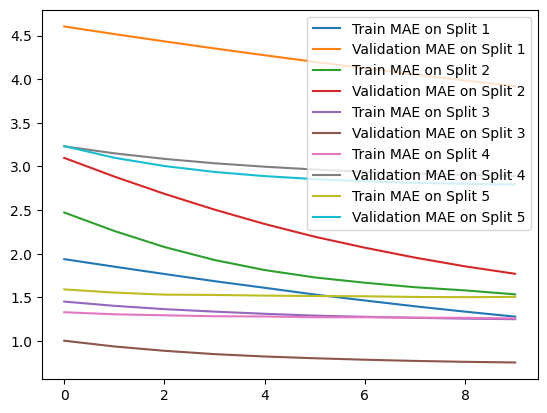

In [36]:
fig, ax = plt.subplots()

for i, hist in enumerate(histories):
    ax.plot(hist.history["mae"], label=f"Train MAE on Split {i+1}")
    ax.plot(hist.history["val_mae"], label=f"Validation MAE on Split {i+1}")
ax.legend()
history.history.keys()